In [ ]:
# Setup to equivalently run in colab or run locally
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    %cd /content
    # Colab-specific widget support
    from google.colab import output
    output.enable_custom_widget_manager()
    !pip install -q ipympl
    %matplotlib widget

    # Clone repo and cd into it to behave like running locally
    if not os.path.exists("arc_zte"):
      print("Cloning repo")
      !git clone https://github.com/mikgroup/arc_zte.git
    %cd /content/arc_zte
else:
    # Local Jupyter 
    %matplotlib notebook

In [1]:
import matplotlib.pyplot as plt
import glob

from zte_recon.traj_zte import Traj_ArcZTE_from_kacq, Traj_CalcPhyllo_ZTE, Traj_RadialZTE_from_kacq
from zte_recon.plot import plot_3d_axes, plot_spokes_temporal_color

In [2]:
# Path that points to data dir with kacq files from scan
data_h5_dir = './example_traj_kacq_files/'

In [3]:
# Parameters for generating trajectory
opxres = 256
num_segs = 172
num_segs_lowres = 4
spokes_per_seg = 384

In [21]:
### Generate trajectories ###

### Standard ZTE - calculates traj from endpoints kacq saved by sequence code
endpoints_txt_path = glob.glob(data_h5_dir + 'kacq_stdzte*')[-1]
stdZTE = Traj_RadialZTE_from_kacq(opxres, endpoints_txt_path, 
                                  spokes_per_seg, num_segs_lowres)

### Phyllotaxis ZTE - calculates trajectory from formula
smoothness = 10
gm_flag = False
segsPerInterleaf = 1
phylloZTE = Traj_CalcPhyllo_ZTE(opxres, smoothness, 
                                gm_flag, segsPerInterleaf, 
                                spokes_per_seg, num_segs, 
                                num_segs_lowres)

### AZTEK - calculates traj from endpoints kacq saved by sequence code
endpoints_txt_path = glob.glob(data_h5_dir + 'kacq_aztek*')[-1]
aztekZTE = Traj_RadialZTE_from_kacq(opxres, endpoints_txt_path, 
                                    spokes_per_seg, num_segs_lowres)

### ArcZTE 53 deg - calculates traj from grad kacq saved by sequence code
seg_rot_file = 'rot_txt_files/seg_golden3d_rotMats.txt'
kacq_file = glob.glob(data_h5_dir + 'kacq_arc_zte*')[-1]
arcZTE = Traj_ArcZTE_from_kacq(opxres, seg_rot_file, kacq_file)

# Plot trajectories

In [22]:
def plot_spokes_one_seg(trajZTEobj, plot_seg_num, spokes_per_seg, title=None, elev=16, azim=140):
    '''Function for plotting spokes of a single segment given a trajectory object
    '''
    plot_3d_axes()
    ax = plt.gca()
    plot_spokes_temporal_color(
        ax, 
        trajZTEobj.coord_sampl_hires[plot_seg_num*spokes_per_seg : (plot_seg_num+1)*spokes_per_seg, :]
    )
    if title is not None:
        plt.title(title)

    ax.elev = elev
    ax.azim = azim

<IPython.core.display.Javascript object>


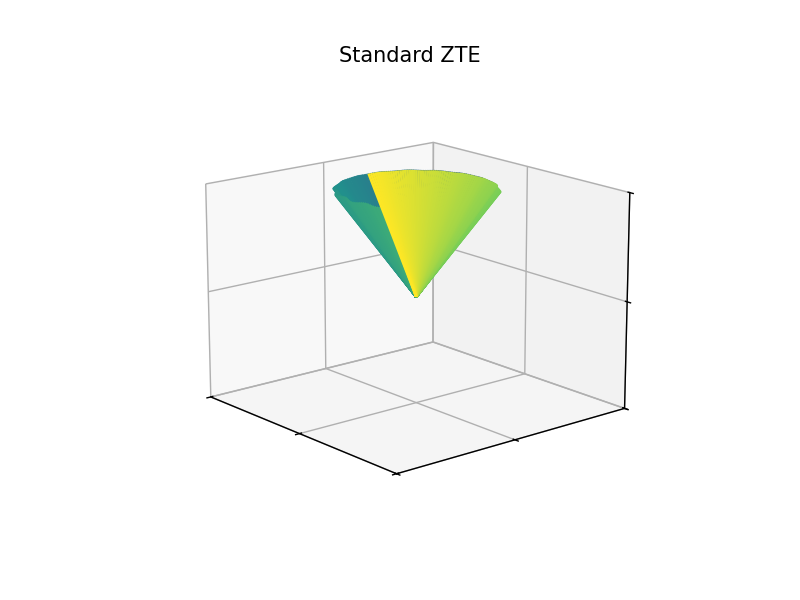

In [23]:
plot_spokes_one_seg(stdZTE, 10, spokes_per_seg, title='Standard ZTE')

<IPython.core.display.Javascript object>


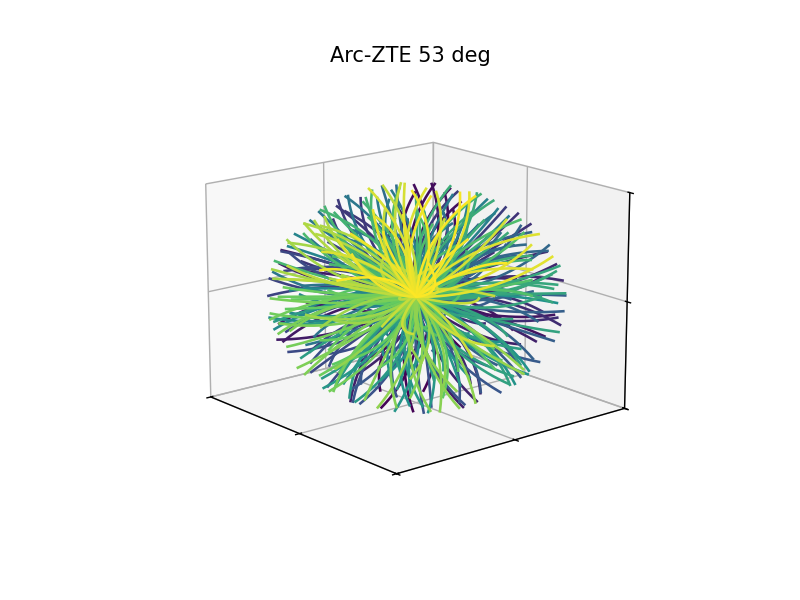

In [33]:
plot_spokes_one_seg(arcZTE, 0, spokes_per_seg, title='Arc-ZTE 53 deg')

<IPython.core.display.Javascript object>


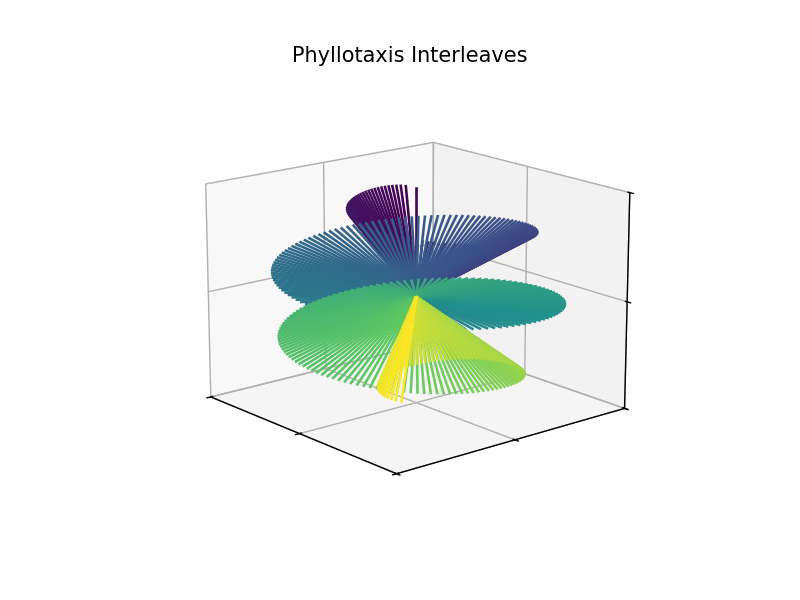

In [47]:
plot_spokes_one_seg(phylloZTE, 0, spokes_per_seg, title='Phyllotaxis Interleave, smoothness=10')

<IPython.core.display.Javascript object>


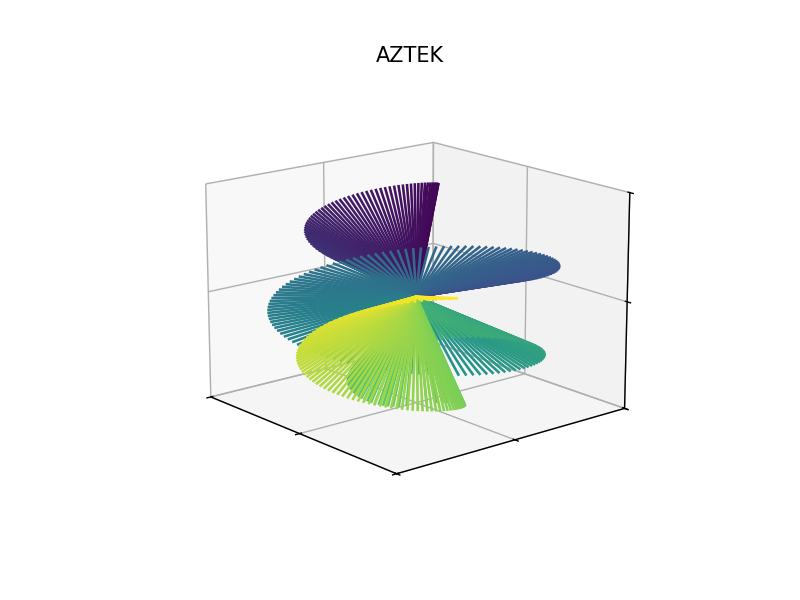

In [40]:
plot_spokes_one_seg(aztekZTE, 0, spokes_per_seg, title='AZTEK; [Shuffle, Speed, Twist] = [1,2,5]')